In [1]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

In [5]:
#фильтруем фичи (дата) по значению классификационных лэйблов (таргет), берем или цифру 3 или цифру 7
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
#тоже самое для тестового набора
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
#необходимы препроцессинг лейблов, видимо не все значения имею тип integer, а нам нужен именно этот тип функция лонг позволяет нам 
#        это сделать (self.long() is equivalent to self.to(torch.int64). See to())
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

In [6]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=True)

In [7]:
def sigm_func(h):
    ''' преобразование в "вероятности" '''
    return 1/(1+np.exp(-h))


def sigmoid_derivative(a):
    ''' производная сигмоиды '''
    return a * (1 - a)

learning_rate = 0.01
epochs = 5
batch_size = 128
hidden_neuro = 300

w1 = np.random.rand(784, hidden_neuro) * 0.01 # array filled with 0.01

b1 = np.zeros(hidden_neuro) # 300 нулей

w2 = np.random.rand(hidden_neuro,1) * 0.01 # колонка с 300 элементами равными 0.01

b2 = np.zeros(1)  # один ноль

losses = []

## двуслойный персептрон

In [8]:
for n_epoch in range(epochs):
    print(f'Epoch: {n_epoch + 1}')

    for x, y in train_loader:

        x = x.view(x.shape[0], -1).numpy() # приводим к размерности (128,784)
        y = np.expand_dims(y.numpy(), 1) # приводим к размерности (128,1)

        # forward
        z1 = x.dot(w1) + b1 # (128, hidden_neuro)
        a1 = sigm_func(z1) # (128, hidden_neuro)
        z2 = a1.dot(w2) + b2 # (128, 1)
        p = sigm_func(z2) # (128, 1)
        
        bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size
        losses.append(bce)

        # BACKWARD

        dp = (p - y) / batch_size # (128, 1) 
        dE_dW2 = a1.T @ dp # (hidden_neuro, 128) @ (128, 1)  -> hidden_neuro, 1
        dE_db2 = np.expand_dims(np.sum(dp), 0) # (1,)
        dE_da1 = dp @ w2.T # (128, 1) @ (1, hidden_neuro) -> (128, hidden_neuro)
        dE_dz1 = dE_da1 * sigmoid_derivative(a1) # -> (128, hidden_neuro)
        dE_dW1 = x.T @ dE_dz1 # (784, 128) @ (128, hidden_neuro) -> (784, hidden_neuro)
        dE_db1 = dE_dz1.T @ np.ones((128,)) # (128, hidden_neuro).T @ (128,) -> (hidden_neuro,)

        # обновим веса
        w1 -= learning_rate * dE_dW1
        b1 -= learning_rate * dE_db1
        w2 -= learning_rate * dE_dW2
        b2 -= learning_rate * dE_db2

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


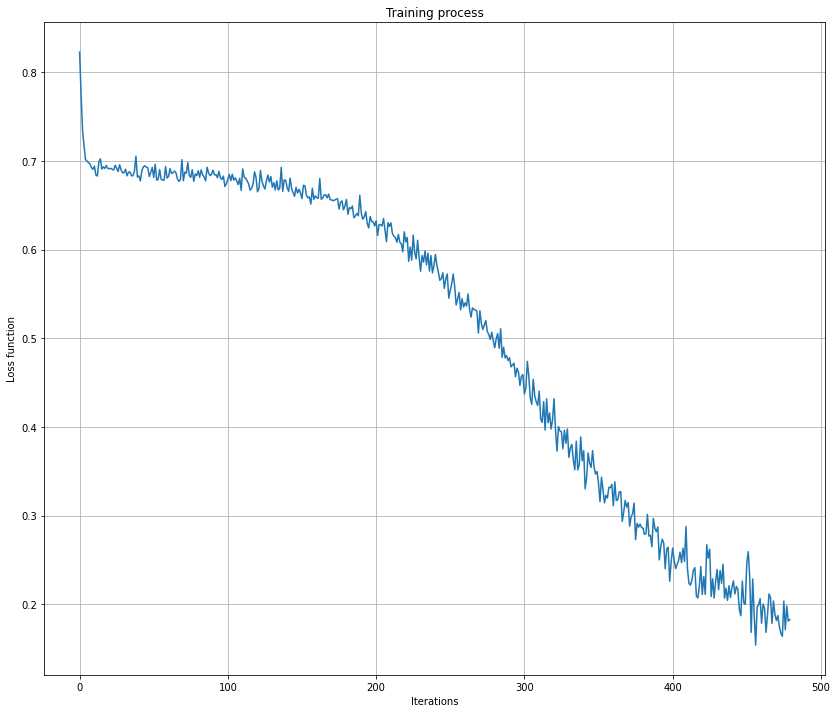

In [9]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

## тестирование

In [10]:
losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:

    x = x.view(x.shape[0], -1).numpy()
    y = np.expand_dims(y.numpy(), 1)

    # forward
    z1 = x.dot(w1) + b1 
    a1 = sigm_func(z1) 
    z2 = a1.dot(w2) + b2 
    p = sigm_func(z2)

    bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 
    losses_test.append(bce)
    predicted.extend(p)
    true_lbls.extend(y)

In [11]:
print(len(predicted), len(true_lbls))

1920 1920


Теперь применим стандартную Ф меру и оценим нашу модель

In [12]:
from sklearn.metrics import f1_score
pred = np.array([round(i[0]) for i in predicted]) 
# У нас были вероятности а нужны классы поэтому просто округлим каждое значени и получим лейблы 
t_lbls = np.array(true_lbls).squeeze() #снимем лишнюю размерность
f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

F1 score is equal to: 0.97
